In [52]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import pdal

import xarray as xr
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [53]:
data_dir = Path("../data")
plots_lidar_dir = data_dir / "outputs" / "plots" / "lidar"
plots_gdf = gpd.read_file("../data/outputs/plots/plots.geojson")
plots = plots_gdf["id"].to_list()

In [182]:
def read_plot(plot_id: str):
    file_path = plots_lidar_dir / f"{plot_id}.copc.laz"
    pl = pdal.Reader(str(file_path)).pipeline()
    pl.execute()
    return pl.arrays[0]

def points_to_xr_ds(points: np.ndarray):
    ds = xr.Dataset(
        data_vars={
            "x": ("point", points["X"]),
            "y": ("point", points["Y"]),
            "z": ("point", points["Z"]),
            "rn": ("point", points["ReturnNumber"]),
            "weights": ("point", 1 / points["NumberOfReturns"])
        },
        coords={
            "point": np.arange(len(points))
        }
    )
    return ds

def read_plot_as_xr_ds(plot_id: str):
    points = read_plot(plot_id)
    ds = points_to_xr_ds(points)
    return ds

In [183]:
points_ds = read_plot_as_xr_ds("AGG_O_01_P5")
points_ds.head()

<xarray.Dataset> Size: 205B
Dimensions:  (point: 5)
Coordinates:
  * point    (point) int64 40B 0 1 2 3 4
Data variables:
    x        (point) float64 40B 4.633e+05 4.633e+05 ... 4.633e+05 4.633e+05
    y        (point) float64 40B 5.26e+06 5.26e+06 5.26e+06 5.26e+06 5.26e+06
    z        (point) float64 40B 55.91 48.16 54.33 48.04 41.02
    rn       (point) uint8 5B 1 1 1 1 1
    weights  (point) float64 40B 0.3333 0.5 0.25 0.25 0.3333

In [185]:
bin_size = 1
my_z_bins = np.arange(-bin_size, points_ds['z'].max() + bin_size, bin_size)

my_z_bins

z_groups = points_ds.groupby(z=xr.groupers.BinGrouper(bins=my_z_bins, labels=my_z_bins[1:]),)
z_groups

<DatasetGroupBy, grouped over 1 grouper(s), 75 groups in total:
    'z_bins': BinGrouper('z'), 75/75 groups with labels 0.0, 1.0, 2.0, ..., 72.0, 73.0, 74.0>

In [186]:
def foo(subset_points_ds):
    z = subset_points_ds['z']

    return xr.Dataset(
        data_vars={
            "inside": z.count(),
        }
    )


hp = z_groups.map(foo)

hp['%_inside'] =hp['inside'] / points_ds['z'].count() * 100


k = 0.5
dz = bin_size

hp['entries'] = hp['inside'].cumsum(dim='z_bins')
hp['exits'] = hp['entries'].shift(z_bins=1)


# Could call voxel penetration ratio ?
hp['gf'] = hp['exits'] / hp['entries']
hp['vad'] = - np.log(hp['gf']) * (1 / k) * (1 / dz)

# hp['count%'] = hp['count'] / points_ds['z'].count() * 100
hp.head()

<xarray.Dataset> Size: 280B
Dimensions:   (z_bins: 5)
Coordinates:
  * z_bins    (z_bins) float64 40B 0.0 1.0 2.0 3.0 4.0
Data variables:
    inside    (z_bins) int64 40B 21951 19465 6475 7940 7340
    %_inside  (z_bins) float64 40B 7.78 6.899 2.295 2.814 2.601
    entries   (z_bins) int64 40B 21951 41416 47891 55831 63171
    exits     (z_bins) float64 40B nan 2.195e+04 4.142e+04 4.789e+04 5.583e+04
    gf        (z_bins) float64 40B nan 0.53 0.8648 0.8578 0.8838
    vad       (z_bins) float64 40B nan 1.27 0.2905 0.3068 0.247

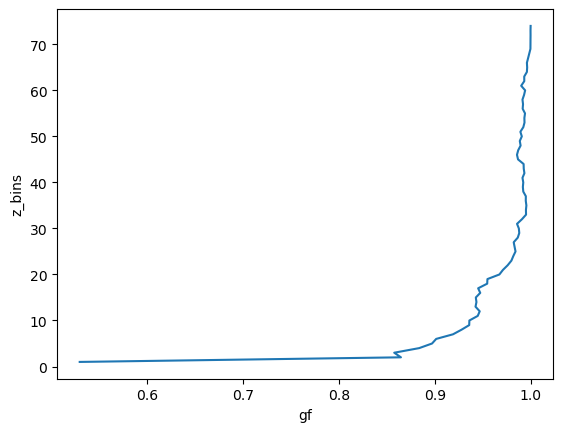

In [181]:
hp['gf'].plot(y='z_bins',)

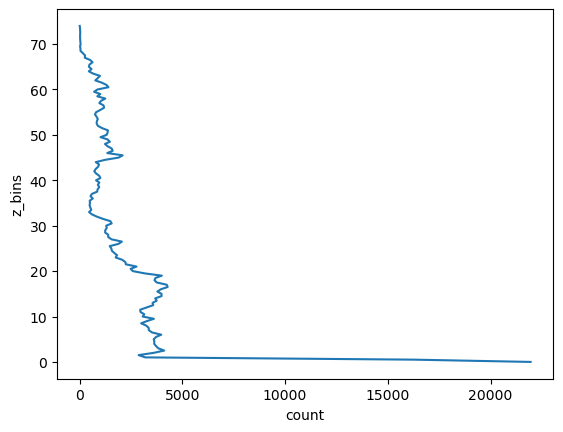

In [162]:
hp['count'].plot(y='z_bins')

In [51]:
def render_plot_height_profile(plot):
    points = read_plot_as_xr_ds(plot)

    max = points['z'].quantile(0.99)
    # max = points['z'].max()
    bin_size = 1
    z_bins = np.arange(-bin_size, max, bin_size)
    
    # z_bins = np.linspace(0.5, max.item(), 50)

    total = len(points.z)
    height_groups = points.groupby(z=xr.groupers.BinGrouper(bins=z_bins, include_lowest=False, labels=z_bins[1:]))
    density_profile = height_groups.count()['z'] / total  * 100
    density_profile.plot(y='z_bins')

plot_dropdown = widgets.Dropdown(
    options=plots,
    value=plots[0] if plots else None,
    description='plot:',
    disabled=False,
)

# Create interactive plot
interactive_plot = widgets.interactive(render_plot_height_profile, plot=plot_dropdown)
display(interactive_plot)

interactive(children=(Dropdown(description='plot:', options=('AGG_O_01_P1', 'AGG_O_01_P2', 'AGG_O_01_P3', 'AGG…